In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
import shap
import optuna
import time

from processing_functions import *

random_state = 42

pd.set_option('display.max_rows', 150)
pd.set_option('display.max_colwidth', None)  # Show full strings in columns

X_trainval, y_trainval, X_test, description, description_X_trainval, numerical_vars, cat_vars, binary_vars = load_data()

print("# training+validation obs: ", X_trainval.shape[0])
print("# test obs: ", X_test.shape[0])
print("# features", X_test.shape[1])

/Users/fdd838/Library/CloudStorage/OneDrive-Sky/Desktop/personal/home-credit-default-risk/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/fdd838/Library/CloudStorage/OneDrive-Sky/Desktop/personal/home-credit-default-risk/processing_functions.py:40: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['CODE_GENDER'] = X['CODE_GENDER'].replace({'M': 1, 'F': 0, 'XNA': np.nan})
/Users/fdd838/Library/CloudStorage/OneDrive-Sky/Desktop/personal/home-credit-default-risk/processing_functions.py:40: FutureWarning: Downcasting behavior in `replace` is deprecated and will be remo

# training+validation obs:  307511
# test obs:  48744
# features 120


In [2]:
print(description[description.Feature=='TARGET'].Description.values[0])
vc = y_trainval.value_counts(dropna=False)
pct = (vc / len(y_trainval)) * 100
display(pd.DataFrame({'count': vc, 'percent': pct.round(2)}))

Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)


,count,percent
TARGET,,
0,282686,91.93
1,24825,8.07


In [3]:
description_X_trainval[description_X_trainval.TYPE=='BINARY']

,Feature,Description,Special,dtype,TYPE,nunique,NaN count,NaN %
0,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,,int64,BINARY,2,0,0.0
2,FLAG_OWN_CAR,Flag if the client owns a car,,int64,BINARY,2,0,0.0
3,FLAG_OWN_REALTY,Flag if client owns a house or flat,,int64,BINARY,2,0,0.0
20,FLAG_MOBIL,"Did client provide mobile phone (1=YES, 0=NO)",,int64,BINARY,2,0,0.0
21,FLAG_EMP_PHONE,"Did client provide work phone (1=YES, 0=NO)",,int64,BINARY,2,0,0.0
22,FLAG_WORK_PHONE,"Did client provide home phone (1=YES, 0=NO)",,int64,BINARY,2,0,0.0
23,FLAG_CONT_MOBILE,"Was mobile phone reachable (1=YES, 0=NO)",,int64,BINARY,2,0,0.0
24,FLAG_PHONE,"Did client provide home phone (1=YES, 0=NO)",,int64,BINARY,2,0,0.0
25,FLAG_EMAIL,"Did client provide email (1=YES, 0=NO)",,int64,BINARY,2,0,0.0
32,REG_REGION_NOT_LIVE_REGION,"Flag if client's permanent address does not match contact address (1=different, 0=same, at region level)",,int64,BINARY,2,0,0.0


In [4]:
display(description_X_trainval.TYPE.value_counts())
description_X_trainval.to_csv("data/preprocessed/description_training_set.csv", index=False)
description_X_trainval#.sort_values(['TYPE', 'NaN count'], ascending=[True, False])

TYPE
NUMERIC        73
BINARY         35
CATEGORICAL    12
Name: count, dtype: int64

,Feature,Description,Special,dtype,TYPE,nunique,NaN count,NaN %
0,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,,int64,BINARY,2,0,0.00
1,CODE_GENDER,Gender of the client,,float64,NUMERIC,2,4,0.00
2,FLAG_OWN_CAR,Flag if the client owns a car,,int64,BINARY,2,0,0.00
3,FLAG_OWN_REALTY,Flag if client owns a house or flat,,int64,BINARY,2,0,0.00
4,CNT_CHILDREN,Number of children the client has,,int64,NUMERIC,15,0,0.00
5,AMT_INCOME_TOTAL,Income of the client,,float64,NUMERIC,2548,0,0.00
6,AMT_CREDIT,Credit amount of the loan,,float64,NUMERIC,5603,0,0.00
7,AMT_ANNUITY,Loan annuity,,float64,NUMERIC,13672,12,0.00
8,AMT_GOODS_PRICE,For consumer loans it is the price of the goods for which the loan is given,,float64,NUMERIC,1002,278,0.09
9,NAME_TYPE_SUITE,Who was accompanying client when he was applying for the loan,,object,CATEGORICAL,7,1292,0.42


In [5]:
for col in cat_vars:
    print(f"{col}: {description[description.Feature==col].Description}")
    vc = X_trainval[col].value_counts(dropna=False)
    pct = (vc / len(X_trainval)) * 100
    display(pd.DataFrame({'count': vc, 'percent': pct.round(2)}))

NAME_TYPE_SUITE: 11    Who was accompanying client when he was applying for the loan
Name: Description, dtype: object


,count,percent
NAME_TYPE_SUITE,,
Unaccompanied,248526,80.82
Family,40149,13.06
"Spouse, partner",11370,3.70
Children,3267,1.06
Other_B,1770,0.58
NaN,1292,0.42
Other_A,866,0.28
Group of people,271,0.09


NAME_INCOME_TYPE: 12    Clients income type (businessman, working, maternity leave,ï¿½)
Name: Description, dtype: object


,count,percent
NAME_INCOME_TYPE,,
Working,158774,51.63
Commercial associate,71617,23.29
Pensioner,55362,18.00
State servant,21703,7.06
Unemployed,22,0.01
Student,18,0.01
Businessman,10,0.00
Maternity leave,5,0.00


NAME_EDUCATION_TYPE: 13    Level of highest education the client achieved
Name: Description, dtype: object


,count,percent
NAME_EDUCATION_TYPE,,
Secondary / secondary special,218391,71.02
Higher education,74863,24.34
Incomplete higher,10277,3.34
Lower secondary,3816,1.24
Academic degree,164,0.05


NAME_FAMILY_STATUS: 14    Family status of the client
Name: Description, dtype: object


,count,percent
NAME_FAMILY_STATUS,,
Married,196432,63.88
Single / not married,45444,14.78
Civil marriage,29775,9.68
Separated,19770,6.43
Widow,16088,5.23
NaN,2,0.00


NAME_HOUSING_TYPE: 15    What is the housing situation of the client (renting, living with parents, ...)
Name: Description, dtype: object


,count,percent
NAME_HOUSING_TYPE,,
House / apartment,272868,88.73
With parents,14840,4.83
Municipal apartment,11183,3.64
Rented apartment,4881,1.59
Office apartment,2617,0.85
Co-op apartment,1122,0.36


OCCUPATION_TYPE: 28    What kind of occupation does the client have
Name: Description, dtype: object


,count,percent
OCCUPATION_TYPE,,
NaN,96391,31.35
Laborers,55186,17.95
Sales staff,32102,10.44
Core staff,27570,8.97
Managers,21371,6.95
Drivers,18603,6.05
High skill tech staff,11380,3.70
Accountants,9813,3.19
Medicine staff,8537,2.78


WEEKDAY_APPR_PROCESS_START: 32    On which day of the week did the client apply for the loan
Name: Description, dtype: object


,count,percent
WEEKDAY_APPR_PROCESS_START,,
TUESDAY,53901,17.53
WEDNESDAY,51934,16.89
MONDAY,50714,16.49
THURSDAY,50591,16.45
FRIDAY,50338,16.37
SATURDAY,33852,11.01
SUNDAY,16181,5.26


ORGANIZATION_TYPE: 40    Type of organization where client works
Name: Description, dtype: object


,count,percent
ORGANIZATION_TYPE,,
Business Entity Type 3,67992,22.11
NaN,55374,18.01
Self-employed,38412,12.49
Other,16683,5.43
Medicine,11193,3.64
Business Entity Type 2,10553,3.43
Government,10404,3.38
School,8893,2.89
Trade: type 7,7831,2.55


FONDKAPREMONT_MODE: 86    Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor
Name: Description, dtype: object


,count,percent
FONDKAPREMONT_MODE,,
NaN,210295,68.39
reg oper account,73830,24.01
reg oper spec account,12080,3.93
not specified,5687,1.85
org spec account,5619,1.83


HOUSETYPE_MODE: 87    Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor
Name: Description, dtype: object


,count,percent
HOUSETYPE_MODE,,
NaN,154297,50.18
block of flats,150503,48.94
specific housing,1499,0.49
terraced house,1212,0.39


WALLSMATERIAL_MODE: 89    Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor
Name: Description, dtype: object


,count,percent
WALLSMATERIAL_MODE,,
NaN,156341,50.84
Panel,66040,21.48
"Stone, brick",64815,21.08
Block,9253,3.01
Wooden,5362,1.74
Mixed,2296,0.75
Monolithic,1779,0.58
Others,1625,0.53


EMERGENCYSTATE_MODE: 90    Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor
Name: Description, dtype: object


,count,percent
EMERGENCYSTATE_MODE,,
No,159428,51.84
NaN,145755,47.40
Yes,2328,0.76


In [6]:
X_trainval = feature_engineering(X_trainval, additional_features=True)
X_test = feature_engineering(X_test, additional_features=True)

/Users/fdd838/Library/CloudStorage/OneDrive-Sky/Desktop/personal/home-credit-default-risk/processing_functions.py:64: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['NAME_EDUCATION_TYPE_ORDINAL'] = X['NAME_EDUCATION_TYPE'].replace(education_order).astype('int64')
/Users/fdd838/Library/CloudStorage/OneDrive-Sky/Desktop/personal/home-credit-default-risk/processing_functions.py:64: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  X['NAME_EDUCATION_TYPE_ORDINAL'] = X['NAME_EDUCATION_TYPE'].replace(education_order).astype('int64')
/Users/fdd838/Library/C

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=random_state, stratify=y_trainval)

scale_weight = np.sum(y_train == 0) / np.sum(y_train == 1)
print(f"Class Imbalance Ratio (scale_pos_weight): {scale_weight:.2f}")

FIXED_PARAMS =  {
    # Fixed parameters
    "booster": "gbtree",
    "tree_method": "hist",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "device": "cuda",
    "verbosity": 0,
    'seed': random_state,
    'max_cat_to_onehot': 1
}

INITIAL_PARAMS = {
    'scale_pos_weight': scale_weight,
    'max_depth': 6,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bynode': 0.8,
    'reg_lambda': 1,  # L2 regularization
    'min_child_weight': 1,
}

params = INITIAL_PARAMS.copy()
params.update(FIXED_PARAMS)

Class Imbalance Ratio (scale_pos_weight): 11.39


/Users/fdd838/Library/CloudStorage/OneDrive-Sky/Desktop/personal/home-credit-default-risk/.venv/lib/python3.13/site-packages/xgboost/training.py:225: UserWarning: [13:49:16] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  return getattr(self.bst, name)(*args, **kwargs)


Best Iteration: 116
Best CV AUC: 0.75883 +/- 0.00384
AUC on validation_set: 0.76391


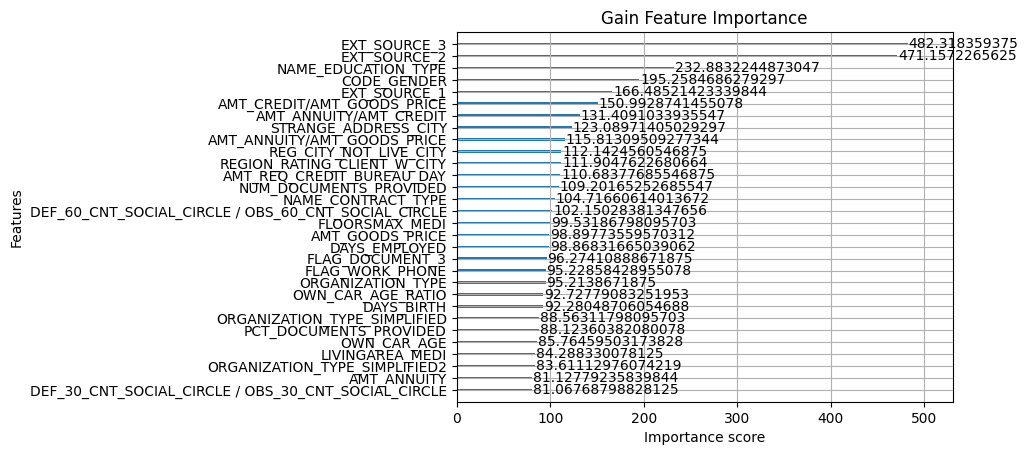

/Users/fdd838/Library/CloudStorage/OneDrive-Sky/Desktop/personal/home-credit-default-risk/processing_functions.py:228: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_val)


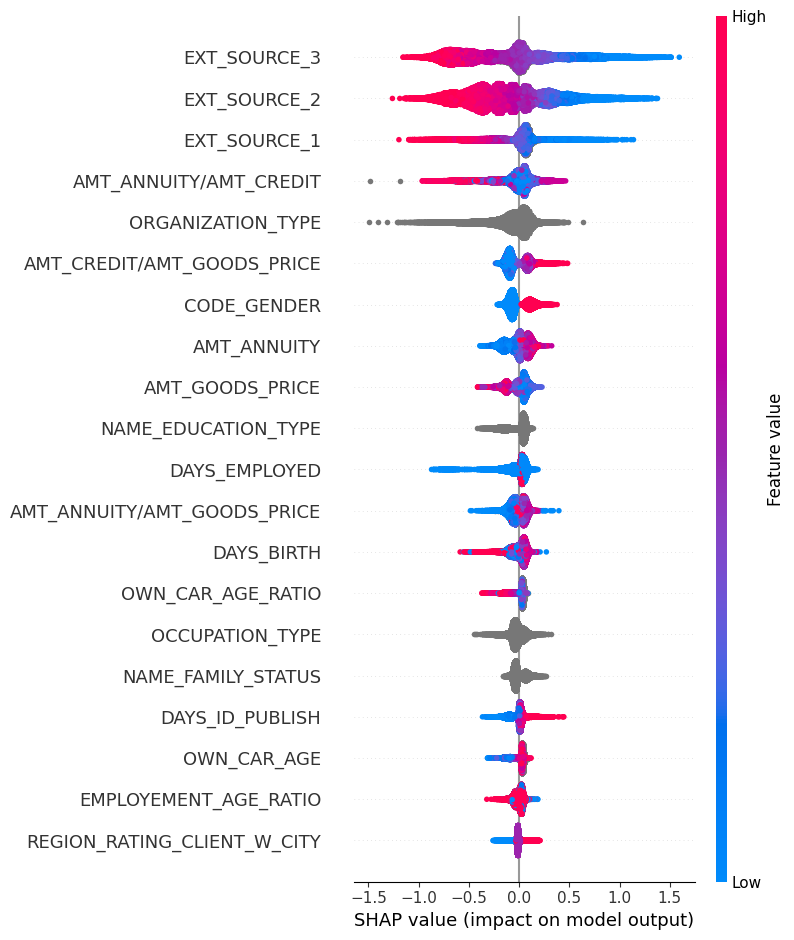

In [8]:
importance, shap_values, model = model_training_and_evaluation(
    params=params, 
    X_trainval=X_trainval, 
    y_trainval=y_trainval,
    X_train=X_train, 
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test, 
    submission_name="submission1", 
    seed=random_state,
    nfold=5, 
    num_boost_round=1000, 
    early_stopping_rounds=10,
    stratified=True, 
    metrics="auc",
)

In [9]:
#get_ordered_importance(importance)
shap_importance = get_ordered_shap_importance(X_val, shap_values)
shap_importance

,Feature,shap_importance,%shap_importance,CUMSUM %shap_importance
0,EXT_SOURCE_3,0.396684,14.603722,14.603722
1,EXT_SOURCE_2,0.348508,12.830170,27.433891
2,EXT_SOURCE_1,0.161920,5.960994,33.394886
3,AMT_ANNUITY/AMT_CREDIT,0.122824,4.521702,37.916588
4,ORGANIZATION_TYPE,0.121060,4.456769,42.373356
5,AMT_CREDIT/AMT_GOODS_PRICE,0.099467,3.661814,46.035172
6,CODE_GENDER,0.092523,3.406196,49.441368
7,AMT_ANNUITY,0.082180,3.025413,52.466782
8,AMT_GOODS_PRICE,0.077209,2.842406,55.309189
9,NAME_EDUCATION_TYPE,0.074703,2.750167,58.059357


Best Iteration: 126
Best CV AUC: 0.75814 +/- 0.00355
AUC on validation_set: 0.76300


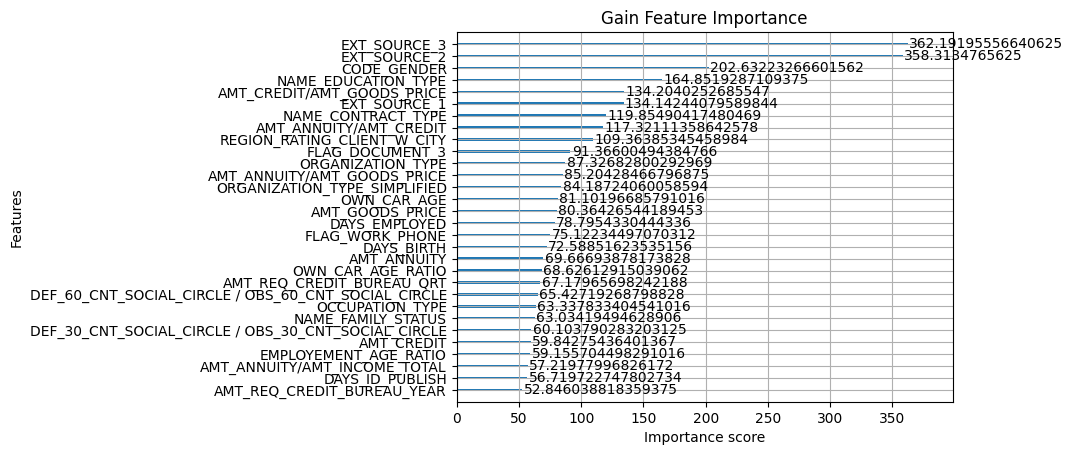

/Users/fdd838/Library/CloudStorage/OneDrive-Sky/Desktop/personal/home-credit-default-risk/processing_functions.py:228: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_val)


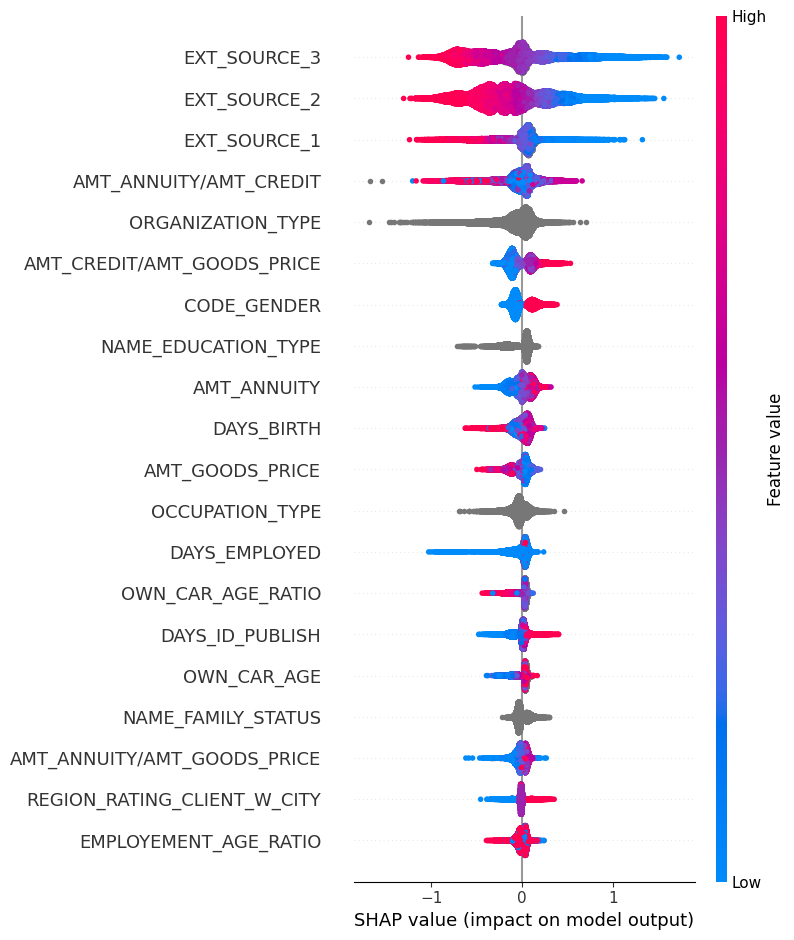

In [10]:
to_keep = shap_importance.iloc[:35].Feature.tolist()
importance, shap_values, model = model_training_and_evaluation(
    params=params, 
    X_trainval=X_trainval[to_keep], 
    y_trainval=y_trainval,
    X_train=X_train[to_keep], 
    y_train=y_train,
    X_val=X_val[to_keep],
    y_val=y_val,
    X_test=X_test[to_keep], 
    submission_name="submission2", 
    seed=random_state,
    nfold=5, 
    num_boost_round=1000, 
    early_stopping_rounds=10,
    stratified=True, 
    metrics="auc",
)

In [12]:
dtrainval = xgb.DMatrix(X_trainval, label=y_trainval, enable_categorical=True)
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dval = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)

def objective(trial):

    optuna_params = {
        # Tuned parameters
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "eta": 0.3,
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0.7, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 100.0, log=True),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 200),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 5.0, 15.0),
    }
    optuna_params.update(FIXED_PARAMS)

    num_boost_round = 10000

    model = xgb.train(params=optuna_params, dtrain=dtrain, num_boost_round=num_boost_round,
                      evals=[(dtrain, 'train'), (dval, 'valid')],
                      early_stopping_rounds=50,
                      verbose_eval=0)
    trial.set_user_attr('best_iteration', model.best_iteration)
    return model.best_score


study = optuna.create_study(
    study_name="optuna_study_3",
    storage="sqlite:///optuna.db",
    load_if_exists=True,
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=random_state),
    pruner=optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=20),
)

tic = time.time()
while time.time() - tic < 60*10:
    study.optimize(objective, n_trials=1, timeout=None, show_progress_bar=True, n_jobs=-1)

print("Best CV AUC:", study.best_value)
print("Best hyperparameters:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")

[I 2025-12-29 13:51:23,532] A new study created in RDB with name: optuna_study_3
Best trial: 0. Best value: 0.757509: 100%|██████████| 1/1 [00:03<00:00,  3.10s/it]


[I 2025-12-29 13:51:26,662] Trial 0 finished with value: 0.7575086538237862 and parameters: {'max_depth': 8, 'subsample': 0.9835429692161758, 'colsample_bynode': 0.761075795953978, 'reg_lambda': 0.47743569609305414, 'min_child_weight': 57, 'scale_pos_weight': 6.225372364052683}. Best is trial 0 with value: 0.7575086538237862.


Best trial: 0. Best value: 0.757509: 100%|██████████| 1/1 [00:02<00:00,  2.99s/it]


[I 2025-12-29 13:51:29,656] Trial 1 finished with value: 0.7572128889634139 and parameters: {'max_depth': 10, 'subsample': 0.8974542279093283, 'colsample_bynode': 0.908841403522776, 'reg_lambda': 52.515151079965634, 'min_child_weight': 101, 'scale_pos_weight': 14.899642926978823}. Best is trial 0 with value: 0.7575086538237862.


Best trial: 0. Best value: 0.757509: 100%|██████████| 1/1 [00:03<00:00,  3.31s/it]


[I 2025-12-29 13:51:32,964] Trial 2 finished with value: 0.75468887290805 and parameters: {'max_depth': 11, 'subsample': 0.8079253111646765, 'colsample_bynode': 0.7512690472184621, 'reg_lambda': 19.355449123823686, 'min_child_weight': 109, 'scale_pos_weight': 9.121922556459918}. Best is trial 0 with value: 0.7575086538237862.


Best trial: 0. Best value: 0.757509: 100%|██████████| 1/1 [00:02<00:00,  2.95s/it]


[I 2025-12-29 13:51:35,913] Trial 3 finished with value: 0.7518379336312124 and parameters: {'max_depth': 11, 'subsample': 0.7636697792906333, 'colsample_bynode': 0.7899121733446737, 'reg_lambda': 0.031215484778026284, 'min_child_weight': 142, 'scale_pos_weight': 11.915793311278286}. Best is trial 0 with value: 0.7575086538237862.


Best trial: 0. Best value: 0.757509: 100%|██████████| 1/1 [00:03<00:00,  3.05s/it]


[I 2025-12-29 13:51:38,967] Trial 4 finished with value: 0.7566479310388682 and parameters: {'max_depth': 9, 'subsample': 0.7675297852136157, 'colsample_bynode': 0.7833712139907482, 'reg_lambda': 1.6797722425021238, 'min_child_weight': 127, 'scale_pos_weight': 11.70176454599677}. Best is trial 0 with value: 0.7575086538237862.


Best trial: 5. Best value: 0.769176: 100%|██████████| 1/1 [00:04<00:00,  4.12s/it]


[I 2025-12-29 13:51:43,086] Trial 5 finished with value: 0.7691764795109507 and parameters: {'max_depth': 4, 'subsample': 0.9489976653917114, 'colsample_bynode': 0.7133835383622619, 'reg_lambda': 2.4068753476881883, 'min_child_weight': 122, 'scale_pos_weight': 9.60602707196839}. Best is trial 5 with value: 0.7691764795109507.


Best trial: 5. Best value: 0.769176: 100%|██████████| 1/1 [00:03<00:00,  3.17s/it]


[I 2025-12-29 13:51:46,257] Trial 6 finished with value: 0.7556437529721386 and parameters: {'max_depth': 11, 'subsample': 0.8617819422863838, 'colsample_bynode': 0.7845001310770907, 'reg_lambda': 5.0550279176541855, 'min_child_weight': 126, 'scale_pos_weight': 11.681062228420432}. Best is trial 5 with value: 0.7691764795109507.


Best trial: 5. Best value: 0.769176: 100%|██████████| 1/1 [00:04<00:00,  4.42s/it]


[I 2025-12-29 13:51:50,674] Trial 7 finished with value: 0.7664638069087168 and parameters: {'max_depth': 4, 'subsample': 0.9343660371595011, 'colsample_bynode': 0.9256665831772132, 'reg_lambda': 0.03974176924659387, 'min_child_weight': 91, 'scale_pos_weight': 11.757921133784123}. Best is trial 5 with value: 0.7691764795109507.


Best trial: 5. Best value: 0.769176: 100%|██████████| 1/1 [00:03<00:00,  3.28s/it]


[I 2025-12-29 13:51:53,950] Trial 8 finished with value: 0.7570692092516305 and parameters: {'max_depth': 9, 'subsample': 0.7100704393960989, 'colsample_bynode': 0.9341530030571279, 'reg_lambda': 0.24853494749829044, 'min_child_weight': 169, 'scale_pos_weight': 13.693924520727336}. Best is trial 5 with value: 0.7691764795109507.


Best trial: 5. Best value: 0.769176: 100%|██████████| 1/1 [00:03<00:00,  3.61s/it]


[I 2025-12-29 13:51:57,558] Trial 9 finished with value: 0.7508630490193888 and parameters: {'max_depth': 12, 'subsample': 0.7162182183316569, 'colsample_bynode': 0.7274999902878238, 'reg_lambda': 16.10431997269987, 'min_child_weight': 105, 'scale_pos_weight': 12.729750398435982}. Best is trial 5 with value: 0.7691764795109507.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:07<00:00,  7.33s/it]


[I 2025-12-29 13:52:04,883] Trial 10 finished with value: 0.7700584162717857 and parameters: {'max_depth': 3, 'subsample': 0.9940989060421489, 'colsample_bynode': 0.9943820675175594, 'reg_lambda': 0.13379205138742076, 'min_child_weight': 198, 'scale_pos_weight': 8.996089631439727}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:04<00:00,  4.94s/it]


[I 2025-12-29 13:52:09,825] Trial 11 finished with value: 0.7686263713695468 and parameters: {'max_depth': 3, 'subsample': 0.9992675858266982, 'colsample_bynode': 0.9911169659330513, 'reg_lambda': 0.13782053803331992, 'min_child_weight': 192, 'scale_pos_weight': 8.834866410393136}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:03<00:00,  3.05s/it]


[I 2025-12-29 13:52:12,880] Trial 12 finished with value: 0.7620833702485014 and parameters: {'max_depth': 5, 'subsample': 0.9489848061025687, 'colsample_bynode': 0.8651075876599217, 'reg_lambda': 2.6229346640449798, 'min_child_weight': 12, 'scale_pos_weight': 6.44528450334347}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:02<00:00,  2.93s/it]


[I 2025-12-29 13:52:15,806] Trial 13 finished with value: 0.7644892025493677 and parameters: {'max_depth': 6, 'subsample': 0.9232682261684022, 'colsample_bynode': 0.7011969004365165, 'reg_lambda': 0.11820951041374095, 'min_child_weight': 197, 'scale_pos_weight': 7.901629564814861}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:05<00:00,  5.87s/it]


[I 2025-12-29 13:52:21,680] Trial 14 finished with value: 0.7685096588781986 and parameters: {'max_depth': 3, 'subsample': 0.9637764815090198, 'colsample_bynode': 0.839087286503243, 'reg_lambda': 1.0201485622298465, 'min_child_weight': 162, 'scale_pos_weight': 10.442550645275828}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:03<00:00,  3.06s/it]


[I 2025-12-29 13:52:24,741] Trial 15 finished with value: 0.7619154467561801 and parameters: {'max_depth': 6, 'subsample': 0.8748629933175552, 'colsample_bynode': 0.9837610794213704, 'reg_lambda': 0.5532222187417193, 'min_child_weight': 53, 'scale_pos_weight': 7.554941287500105}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:03<00:00,  3.29s/it]


[I 2025-12-29 13:52:28,038] Trial 16 finished with value: 0.7629653836005172 and parameters: {'max_depth': 5, 'subsample': 0.90412556265929, 'colsample_bynode': 0.8591988229795571, 'reg_lambda': 0.01790871801472873, 'min_child_weight': 69, 'scale_pos_weight': 9.826594401749281}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:04<00:00,  4.24s/it]


[I 2025-12-29 13:52:32,276] Trial 17 finished with value: 0.7667842715343319 and parameters: {'max_depth': 4, 'subsample': 0.8257795040157486, 'colsample_bynode': 0.82495993626303, 'reg_lambda': 5.5815864009628156, 'min_child_weight': 162, 'scale_pos_weight': 5.093229529850165}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


[I 2025-12-29 13:52:34,835] Trial 18 finished with value: 0.7527712060763382 and parameters: {'max_depth': 7, 'subsample': 0.9661495130933664, 'colsample_bynode': 0.9586398710373715, 'reg_lambda': 0.07577440314491124, 'min_child_weight': 3, 'scale_pos_weight': 10.415145978102421}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:04<00:00,  4.97s/it]


[I 2025-12-29 13:52:39,807] Trial 19 finished with value: 0.7686941688141586 and parameters: {'max_depth': 3, 'subsample': 0.9912116840240779, 'colsample_bynode': 0.8937744383133401, 'reg_lambda': 0.33343338732942657, 'min_child_weight': 183, 'scale_pos_weight': 8.23148059344259}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:04<00:00,  4.15s/it]


[I 2025-12-29 13:52:43,954] Trial 20 finished with value: 0.7665298801611635 and parameters: {'max_depth': 4, 'subsample': 0.9158988984634331, 'colsample_bynode': 0.8138935813078246, 'reg_lambda': 0.010137036807744429, 'min_child_weight': 31, 'scale_pos_weight': 9.743804911547846}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:06<00:00,  6.88s/it]


[I 2025-12-29 13:52:50,837] Trial 21 finished with value: 0.7695211220130642 and parameters: {'max_depth': 3, 'subsample': 0.9972745493556249, 'colsample_bynode': 0.8871929825076741, 'reg_lambda': 0.2262096254479803, 'min_child_weight': 178, 'scale_pos_weight': 8.126156844530541}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:03<00:00,  3.40s/it]


[I 2025-12-29 13:52:54,236] Trial 22 finished with value: 0.7668063084201459 and parameters: {'max_depth': 5, 'subsample': 0.9723721970193397, 'colsample_bynode': 0.8822386781912488, 'reg_lambda': 0.18111282973932522, 'min_child_weight': 144, 'scale_pos_weight': 7.140244705059551}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:07<00:00,  7.56s/it]


[I 2025-12-29 13:53:01,798] Trial 23 finished with value: 0.7691652758242574 and parameters: {'max_depth': 3, 'subsample': 0.9536071017382719, 'colsample_bynode': 0.9617215194499257, 'reg_lambda': 0.8954070739742787, 'min_child_weight': 177, 'scale_pos_weight': 8.810236249364706}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:03<00:00,  3.93s/it]


[I 2025-12-29 13:53:05,727] Trial 24 finished with value: 0.7668045664160781 and parameters: {'max_depth': 4, 'subsample': 0.9993969234706891, 'colsample_bynode': 0.9452449615206637, 'reg_lambda': 0.050659597538383096, 'min_child_weight': 152, 'scale_pos_weight': 10.913010727300346}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:03<00:00,  3.02s/it]


[I 2025-12-29 13:53:08,747] Trial 25 finished with value: 0.7645303729808828 and parameters: {'max_depth': 6, 'subsample': 0.9440288698747208, 'colsample_bynode': 0.9094839131652757, 'reg_lambda': 2.432582089796989, 'min_child_weight': 197, 'scale_pos_weight': 9.194838311220119}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:05<00:00,  5.08s/it]


[I 2025-12-29 13:53:13,832] Trial 26 finished with value: 0.7686902644451235 and parameters: {'max_depth': 3, 'subsample': 0.8833194346718559, 'colsample_bynode': 0.9717108667754399, 'reg_lambda': 0.8147614563764308, 'min_child_weight': 126, 'scale_pos_weight': 6.763675299313066}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:03<00:00,  3.57s/it]


[I 2025-12-29 13:53:17,403] Trial 27 finished with value: 0.7667163102202167 and parameters: {'max_depth': 5, 'subsample': 0.9754703836148074, 'colsample_bynode': 0.7068540496173332, 'reg_lambda': 0.09292658672059294, 'min_child_weight': 180, 'scale_pos_weight': 5.805788945935744}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:04<00:00,  4.01s/it]


[I 2025-12-29 13:53:21,409] Trial 28 finished with value: 0.7657890671040984 and parameters: {'max_depth': 4, 'subsample': 0.9297766443847879, 'colsample_bynode': 0.8079186106532272, 'reg_lambda': 6.160307532697855, 'min_child_weight': 80, 'scale_pos_weight': 7.505055845723078}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:03<00:00,  3.32s/it]


[I 2025-12-29 13:53:24,728] Trial 29 finished with value: 0.7648935024566355 and parameters: {'max_depth': 7, 'subsample': 0.9828233877243228, 'colsample_bynode': 0.8817545106013033, 'reg_lambda': 0.3182283593115865, 'min_child_weight': 153, 'scale_pos_weight': 8.124224723638148}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:04<00:00,  4.88s/it]


[I 2025-12-29 13:53:29,606] Trial 30 finished with value: 0.7694043881474328 and parameters: {'max_depth': 3, 'subsample': 0.9767204911587339, 'colsample_bynode': 0.7545302784620925, 'reg_lambda': 0.5863281376213995, 'min_child_weight': 117, 'scale_pos_weight': 11.023043711716568}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:06<00:00,  6.65s/it]


[I 2025-12-29 13:53:36,259] Trial 31 finished with value: 0.7689411254992098 and parameters: {'max_depth': 3, 'subsample': 0.9795626158758497, 'colsample_bynode': 0.7521282799868281, 'reg_lambda': 0.4699811631530844, 'min_child_weight': 133, 'scale_pos_weight': 10.966169848367082}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:04<00:00,  4.29s/it]


[I 2025-12-29 13:53:40,554] Trial 32 finished with value: 0.7671336395341875 and parameters: {'max_depth': 4, 'subsample': 0.9557766615890687, 'colsample_bynode': 0.730028943189988, 'reg_lambda': 1.5340343089718382, 'min_child_weight': 112, 'scale_pos_weight': 9.623131965663514}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:05<00:00,  5.27s/it]


[I 2025-12-29 13:53:45,827] Trial 33 finished with value: 0.7689161247128142 and parameters: {'max_depth': 3, 'subsample': 0.997441944222136, 'colsample_bynode': 0.7285548069600951, 'reg_lambda': 0.20536322804688495, 'min_child_weight': 89, 'scale_pos_weight': 8.46339649943045}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:05<00:00,  5.06s/it]


[I 2025-12-29 13:53:50,891] Trial 34 finished with value: 0.7654757610821116 and parameters: {'max_depth': 4, 'subsample': 0.940643792627169, 'colsample_bynode': 0.7738590941084927, 'reg_lambda': 60.489638534400314, 'min_child_weight': 51, 'scale_pos_weight': 12.589589992766212}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:03<00:00,  3.40s/it]


[I 2025-12-29 13:53:54,294] Trial 35 finished with value: 0.765339752956749 and parameters: {'max_depth': 5, 'subsample': 0.9035335235560027, 'colsample_bynode': 0.7594974286288426, 'reg_lambda': 0.5630251027483968, 'min_child_weight': 115, 'scale_pos_weight': 9.309576982940715}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:04<00:00,  4.98s/it]


[I 2025-12-29 13:53:59,272] Trial 36 finished with value: 0.76839217156909 and parameters: {'max_depth': 3, 'subsample': 0.844175519222947, 'colsample_bynode': 0.7395022651645321, 'reg_lambda': 10.341655100079933, 'min_child_weight': 185, 'scale_pos_weight': 11.00991426142961}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:02<00:00,  2.75s/it]


[I 2025-12-29 13:54:02,018] Trial 37 finished with value: 0.7610645810781238 and parameters: {'max_depth': 8, 'subsample': 0.9734033692148594, 'colsample_bynode': 0.8009792482361571, 'reg_lambda': 3.270536922206818, 'min_child_weight': 170, 'scale_pos_weight': 14.798390736099705}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:03<00:00,  3.83s/it]


[I 2025-12-29 13:54:05,850] Trial 38 finished with value: 0.7675347457673308 and parameters: {'max_depth': 4, 'subsample': 0.78420531220228, 'colsample_bynode': 0.7136303799778554, 'reg_lambda': 0.058158674893893696, 'min_child_weight': 135, 'scale_pos_weight': 10.341875099619736}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:03<00:00,  3.63s/it]


[I 2025-12-29 13:54:09,484] Trial 39 finished with value: 0.7587664573518752 and parameters: {'max_depth': 10, 'subsample': 0.9841024144510022, 'colsample_bynode': 0.7674567277505632, 'reg_lambda': 0.02838055667762262, 'min_child_weight': 148, 'scale_pos_weight': 12.582089636396294}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:03<00:00,  3.85s/it]


[I 2025-12-29 13:54:13,337] Trial 40 finished with value: 0.7671694521454205 and parameters: {'max_depth': 3, 'subsample': 0.9590481065502826, 'colsample_bynode': 0.9149021192401346, 'reg_lambda': 38.30179751074853, 'min_child_weight': 94, 'scale_pos_weight': 8.699113224779813}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:04<00:00,  4.45s/it]


[I 2025-12-29 13:54:17,790] Trial 41 finished with value: 0.7686131727497698 and parameters: {'max_depth': 3, 'subsample': 0.9505843208598681, 'colsample_bynode': 0.9598378783774069, 'reg_lambda': 1.1934578918635286, 'min_child_weight': 174, 'scale_pos_weight': 8.878210930016948}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:04<00:00,  4.38s/it]


[I 2025-12-29 13:54:22,174] Trial 42 finished with value: 0.7666297034065299 and parameters: {'max_depth': 4, 'subsample': 0.9146586601888963, 'colsample_bynode': 0.9966207356610678, 'reg_lambda': 0.9365359858697241, 'min_child_weight': 161, 'scale_pos_weight': 9.258711457478105}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:05<00:00,  5.63s/it]


[I 2025-12-29 13:54:27,802] Trial 43 finished with value: 0.7692925222747637 and parameters: {'max_depth': 3, 'subsample': 0.9633649007786161, 'colsample_bynode': 0.9757732501860434, 'reg_lambda': 0.3565175032943028, 'min_child_weight': 200, 'scale_pos_weight': 10.116526294906595}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:05<00:00,  5.64s/it]


[I 2025-12-29 13:54:33,443] Trial 44 finished with value: 0.7691626485686337 and parameters: {'max_depth': 3, 'subsample': 0.9879612279685982, 'colsample_bynode': 0.9378237238537186, 'reg_lambda': 0.15964125813583363, 'min_child_weight': 115, 'scale_pos_weight': 11.297181735437029}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:03<00:00,  3.10s/it]


[I 2025-12-29 13:54:36,539] Trial 45 finished with value: 0.7652250852718115 and parameters: {'max_depth': 5, 'subsample': 0.730765996554522, 'colsample_bynode': 0.9863645737116856, 'reg_lambda': 0.33927700972264097, 'min_child_weight': 200, 'scale_pos_weight': 10.30903394340718}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:04<00:00,  4.62s/it]


[I 2025-12-29 13:54:41,160] Trial 46 finished with value: 0.7671835930148415 and parameters: {'max_depth': 4, 'subsample': 0.9376338581386117, 'colsample_bynode': 0.9723085369417859, 'reg_lambda': 1.9345288122220878, 'min_child_weight': 186, 'scale_pos_weight': 12.206345488377018}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:05<00:00,  5.12s/it]


[I 2025-12-29 13:54:46,278] Trial 47 finished with value: 0.7683971856196531 and parameters: {'max_depth': 3, 'subsample': 0.9662475888492796, 'colsample_bynode': 0.8409079140489285, 'reg_lambda': 0.6068419363277674, 'min_child_weight': 191, 'scale_pos_weight': 10.020431289108668}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


[I 2025-12-29 13:54:49,086] Trial 48 finished with value: 0.7636281466818723 and parameters: {'max_depth': 6, 'subsample': 0.9261322516189019, 'colsample_bynode': 0.925284515710626, 'reg_lambda': 0.10876078418701388, 'min_child_weight': 103, 'scale_pos_weight': 7.762090468884328}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:05<00:00,  5.13s/it]


[I 2025-12-29 13:54:54,218] Trial 49 finished with value: 0.7683843824241123 and parameters: {'max_depth': 4, 'subsample': 0.9992578192438205, 'colsample_bynode': 0.787528000824765, 'reg_lambda': 0.27626484258322487, 'min_child_weight': 192, 'scale_pos_weight': 11.600248930553324}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:03<00:00,  3.32s/it]


[I 2025-12-29 13:54:57,539] Trial 50 finished with value: 0.7596980447910213 and parameters: {'max_depth': 9, 'subsample': 0.8851794269739848, 'colsample_bynode': 0.743154735030836, 'reg_lambda': 4.208470053346613, 'min_child_weight': 168, 'scale_pos_weight': 9.574780819576139}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:05<00:00,  5.93s/it]


[I 2025-12-29 13:55:03,474] Trial 51 finished with value: 0.7689655848037682 and parameters: {'max_depth': 3, 'subsample': 0.9571596111727932, 'colsample_bynode': 0.9992801441376548, 'reg_lambda': 0.7259874140565302, 'min_child_weight': 176, 'scale_pos_weight': 8.494110667127378}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:05<00:00,  5.73s/it]


[I 2025-12-29 13:55:09,203] Trial 52 finished with value: 0.7685487916280638 and parameters: {'max_depth': 3, 'subsample': 0.9869647091990706, 'colsample_bynode': 0.9526653756902854, 'reg_lambda': 0.40385474175108294, 'min_child_weight': 200, 'scale_pos_weight': 10.026491288808426}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:04<00:00,  4.37s/it]


[I 2025-12-29 13:55:13,575] Trial 53 finished with value: 0.768836152832821 and parameters: {'max_depth': 3, 'subsample': 0.9677288309879465, 'colsample_bynode': 0.9739774580342387, 'reg_lambda': 0.23435385542434042, 'min_child_weight': 160, 'scale_pos_weight': 8.99635835365451}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:04<00:00,  4.13s/it]


[I 2025-12-29 13:55:17,710] Trial 54 finished with value: 0.767074929722248 and parameters: {'max_depth': 4, 'subsample': 0.947045107273162, 'colsample_bynode': 0.9813261147522493, 'reg_lambda': 1.734013076115598, 'min_child_weight': 186, 'scale_pos_weight': 8.096790415395294}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:05<00:00,  5.90s/it]


[I 2025-12-29 13:55:23,610] Trial 55 finished with value: 0.7693830459258176 and parameters: {'max_depth': 3, 'subsample': 0.9761613778818148, 'colsample_bynode': 0.9657943097719192, 'reg_lambda': 1.2586291883589433, 'min_child_weight': 135, 'scale_pos_weight': 7.2232880857102995}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:04<00:00,  4.09s/it]


[I 2025-12-29 13:55:27,701] Trial 56 finished with value: 0.7660279496537312 and parameters: {'max_depth': 5, 'subsample': 0.9742352988275409, 'colsample_bynode': 0.9237900445938821, 'reg_lambda': 1.2883905719863686, 'min_child_weight': 122, 'scale_pos_weight': 7.037585640189853}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:04<00:00,  4.73s/it]


[I 2025-12-29 13:55:32,435] Trial 57 finished with value: 0.7674524797142914 and parameters: {'max_depth': 4, 'subsample': 0.9892799509874457, 'colsample_bynode': 0.8974695174769037, 'reg_lambda': 0.13716625590599948, 'min_child_weight': 135, 'scale_pos_weight': 6.516071230388905}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:05<00:00,  5.63s/it]


[I 2025-12-29 13:55:38,063] Trial 58 finished with value: 0.7687775641418187 and parameters: {'max_depth': 3, 'subsample': 0.9164674647657554, 'colsample_bynode': 0.9398181335779239, 'reg_lambda': 0.0729441181358877, 'min_child_weight': 142, 'scale_pos_weight': 7.342322015195606}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:04<00:00,  4.86s/it]


[I 2025-12-29 13:55:42,919] Trial 59 finished with value: 0.7665807580795592 and parameters: {'max_depth': 4, 'subsample': 0.9664382358771412, 'colsample_bynode': 0.859834625597723, 'reg_lambda': 9.165300903262263, 'min_child_weight': 122, 'scale_pos_weight': 10.668868015975836}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:03<00:00,  3.12s/it]


[I 2025-12-29 13:55:46,036] Trial 60 finished with value: 0.7545357511067337 and parameters: {'max_depth': 12, 'subsample': 0.852552071611991, 'colsample_bynode': 0.7137047392164997, 'reg_lambda': 2.5768132794072685, 'min_child_weight': 98, 'scale_pos_weight': 5.814687243930796}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:03<00:00,  3.75s/it]


[I 2025-12-29 13:55:49,788] Trial 61 finished with value: 0.7676041249088876 and parameters: {'max_depth': 3, 'subsample': 0.9536964681488974, 'colsample_bynode': 0.9568799018067943, 'reg_lambda': 0.9300224881839418, 'min_child_weight': 192, 'scale_pos_weight': 7.829735119400241}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:04<00:00,  4.15s/it]


[I 2025-12-29 13:55:53,941] Trial 62 finished with value: 0.7682302738433957 and parameters: {'max_depth': 3, 'subsample': 0.981541463148494, 'colsample_bynode': 0.9660477245432461, 'reg_lambda': 0.42503755756603473, 'min_child_weight': 177, 'scale_pos_weight': 8.522127597497473}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:04<00:00,  4.75s/it]


[I 2025-12-29 13:55:58,689] Trial 63 finished with value: 0.768963221164302 and parameters: {'max_depth': 3, 'subsample': 0.9367095460946966, 'colsample_bynode': 0.9815943726144354, 'reg_lambda': 0.67124323039148, 'min_child_weight': 155, 'scale_pos_weight': 9.460333022140446}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:03<00:00,  3.46s/it]


[I 2025-12-29 13:56:02,154] Trial 64 finished with value: 0.7670507073159931 and parameters: {'max_depth': 4, 'subsample': 0.993104092699826, 'colsample_bynode': 0.9478249684985435, 'reg_lambda': 1.2770659606822834, 'min_child_weight': 82, 'scale_pos_weight': 10.006862423564817}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:04<00:00,  4.64s/it]


[I 2025-12-29 13:56:06,798] Trial 65 finished with value: 0.7678835687229689 and parameters: {'max_depth': 3, 'subsample': 0.976968092270079, 'colsample_bynode': 0.8273882171585564, 'reg_lambda': 0.16778306515418118, 'min_child_weight': 107, 'scale_pos_weight': 9.003041707803426}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:04<00:00,  4.84s/it]


[I 2025-12-29 13:56:11,639] Trial 66 finished with value: 0.7693701946381399 and parameters: {'max_depth': 3, 'subsample': 0.9616677868380099, 'colsample_bynode': 0.8717338088097405, 'reg_lambda': 4.263710494176693, 'min_child_weight': 167, 'scale_pos_weight': 7.06269118966881}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:03<00:00,  3.46s/it]


[I 2025-12-29 13:56:15,103] Trial 67 finished with value: 0.7677153370847337 and parameters: {'max_depth': 4, 'subsample': 0.9609325536244471, 'colsample_bynode': 0.8789600977021793, 'reg_lambda': 3.4192333783212616, 'min_child_weight': 168, 'scale_pos_weight': 5.973186394150459}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:06<00:00,  6.23s/it]


[I 2025-12-29 13:56:21,337] Trial 68 finished with value: 0.7684156351882969 and parameters: {'max_depth': 3, 'subsample': 0.8165112859255733, 'colsample_bynode': 0.86985447528368, 'reg_lambda': 25.316754044009226, 'min_child_weight': 129, 'scale_pos_weight': 7.001580047931806}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 10. Best value: 0.770058: 100%|██████████| 1/1 [00:03<00:00,  3.76s/it]


[I 2025-12-29 13:56:25,101] Trial 69 finished with value: 0.7647181050900113 and parameters: {'max_depth': 5, 'subsample': 0.9918499316319886, 'colsample_bynode': 0.8495682817012709, 'reg_lambda': 5.893690853631716, 'min_child_weight': 142, 'scale_pos_weight': 6.371907377203133}. Best is trial 10 with value: 0.7700584162717857.


Best trial: 70. Best value: 0.770167: 100%|██████████| 1/1 [00:07<00:00,  7.61s/it]


[I 2025-12-29 13:56:32,708] Trial 70 finished with value: 0.7701668106046511 and parameters: {'max_depth': 3, 'subsample': 0.9713387427334625, 'colsample_bynode': 0.8974911201936735, 'reg_lambda': 2.055976667710478, 'min_child_weight': 190, 'scale_pos_weight': 13.483874456385685}. Best is trial 70 with value: 0.7701668106046511.


Best trial: 70. Best value: 0.770167: 100%|██████████| 1/1 [00:05<00:00,  5.96s/it]


[I 2025-12-29 13:56:38,666] Trial 71 finished with value: 0.7691534415962143 and parameters: {'max_depth': 3, 'subsample': 0.9726452438085904, 'colsample_bynode': 0.8980338122208488, 'reg_lambda': 2.1779946728922726, 'min_child_weight': 192, 'scale_pos_weight': 14.287724853677467}. Best is trial 70 with value: 0.7701668106046511.


Best trial: 70. Best value: 0.770167: 100%|██████████| 1/1 [00:07<00:00,  7.21s/it]


[I 2025-12-29 13:56:45,880] Trial 72 finished with value: 0.769125818897766 and parameters: {'max_depth': 3, 'subsample': 0.9472956898622756, 'colsample_bynode': 0.8683125189202481, 'reg_lambda': 7.9335515102205365, 'min_child_weight': 182, 'scale_pos_weight': 13.196207156552187}. Best is trial 70 with value: 0.7701668106046511.


Best trial: 70. Best value: 0.770167: 100%|██████████| 1/1 [00:04<00:00,  4.15s/it]


[I 2025-12-29 13:56:50,032] Trial 73 finished with value: 0.7681361201266056 and parameters: {'max_depth': 4, 'subsample': 0.9814525372650583, 'colsample_bynode': 0.9035211139330586, 'reg_lambda': 2.8147545961019627, 'min_child_weight': 171, 'scale_pos_weight': 13.71553583756379}. Best is trial 70 with value: 0.7701668106046511.


Best trial: 70. Best value: 0.770167: 100%|██████████| 1/1 [00:06<00:00,  6.70s/it]


[I 2025-12-29 13:56:56,734] Trial 74 finished with value: 0.7695520114144371 and parameters: {'max_depth': 3, 'subsample': 0.9651236581098432, 'colsample_bynode': 0.8899900971889403, 'reg_lambda': 3.5461519385311093, 'min_child_weight': 188, 'scale_pos_weight': 6.698348210306803}. Best is trial 70 with value: 0.7701668106046511.


Best trial: 70. Best value: 0.770167: 100%|██████████| 1/1 [00:04<00:00,  4.54s/it]


[I 2025-12-29 13:57:01,273] Trial 75 finished with value: 0.7676788796826289 and parameters: {'max_depth': 3, 'subsample': 0.9633171917265164, 'colsample_bynode': 0.8889111283937321, 'reg_lambda': 12.266506068894284, 'min_child_weight': 195, 'scale_pos_weight': 5.114992394589348}. Best is trial 70 with value: 0.7701668106046511.


Best trial: 70. Best value: 0.770167: 100%|██████████| 1/1 [00:05<00:00,  5.06s/it]


[I 2025-12-29 13:57:06,331] Trial 76 finished with value: 0.7690345738646596 and parameters: {'max_depth': 4, 'subsample': 0.9925651405748787, 'colsample_bynode': 0.9180818324696189, 'reg_lambda': 4.737859327852628, 'min_child_weight': 188, 'scale_pos_weight': 6.689856457800964}. Best is trial 70 with value: 0.7701668106046511.


Best trial: 70. Best value: 0.770167: 100%|██████████| 1/1 [00:06<00:00,  6.07s/it]


[I 2025-12-29 13:57:12,401] Trial 77 finished with value: 0.7681804895758156 and parameters: {'max_depth': 3, 'subsample': 0.9768805633419705, 'colsample_bynode': 0.8775405474197248, 'reg_lambda': 1.638198386948927, 'min_child_weight': 180, 'scale_pos_weight': 7.368562847101676}. Best is trial 70 with value: 0.7701668106046511.


Best trial: 70. Best value: 0.770167: 100%|██████████| 1/1 [00:04<00:00,  4.45s/it]


[I 2025-12-29 13:57:16,849] Trial 78 finished with value: 0.7685455890479884 and parameters: {'max_depth': 3, 'subsample': 0.9696476983914584, 'colsample_bynode': 0.8893539839063972, 'reg_lambda': 3.443748449686144, 'min_child_weight': 200, 'scale_pos_weight': 6.859883615184732}. Best is trial 70 with value: 0.7701668106046511.


Best trial: 70. Best value: 0.770167: 100%|██████████| 1/1 [00:03<00:00,  3.12s/it]


[I 2025-12-29 13:57:19,969] Trial 79 finished with value: 0.7601800829657046 and parameters: {'max_depth': 10, 'subsample': 0.9999486858142326, 'colsample_bynode': 0.8536956877379098, 'reg_lambda': 0.2252160113788847, 'min_child_weight': 163, 'scale_pos_weight': 8.107313038655409}. Best is trial 70 with value: 0.7701668106046511.


Best trial: 70. Best value: 0.770167: 100%|██████████| 1/1 [00:04<00:00,  4.22s/it]


[I 2025-12-29 13:57:24,190] Trial 80 finished with value: 0.7669887664249342 and parameters: {'max_depth': 4, 'subsample': 0.9425022405489756, 'colsample_bynode': 0.9077193262328971, 'reg_lambda': 0.5454708128504839, 'min_child_weight': 183, 'scale_pos_weight': 6.119927967418545}. Best is trial 70 with value: 0.7701668106046511.


Best trial: 70. Best value: 0.770167: 100%|██████████| 1/1 [00:04<00:00,  4.57s/it]


[I 2025-12-29 13:57:28,759] Trial 81 finished with value: 0.7687940597447547 and parameters: {'max_depth': 3, 'subsample': 0.9293707632754507, 'colsample_bynode': 0.8859210957938745, 'reg_lambda': 7.146140651745886, 'min_child_weight': 121, 'scale_pos_weight': 7.255419991705979}. Best is trial 70 with value: 0.7701668106046511.


Best trial: 70. Best value: 0.770167: 100%|██████████| 1/1 [00:06<00:00,  6.19s/it]


[I 2025-12-29 13:57:34,950] Trial 82 finished with value: 0.7685120029245719 and parameters: {'max_depth': 3, 'subsample': 0.9587849747931385, 'colsample_bynode': 0.9892466205493382, 'reg_lambda': 4.120829238837516, 'min_child_weight': 194, 'scale_pos_weight': 5.357613717139663}. Best is trial 70 with value: 0.7701668106046511.


Best trial: 70. Best value: 0.770167: 100%|██████████| 1/1 [00:03<00:00,  3.02s/it]


[I 2025-12-29 13:57:37,970] Trial 83 finished with value: 0.7588076099714878 and parameters: {'max_depth': 11, 'subsample': 0.9821851449781543, 'colsample_bynode': 0.8400409261879137, 'reg_lambda': 1.1645008646630333, 'min_child_weight': 189, 'scale_pos_weight': 7.6533443191350585}. Best is trial 70 with value: 0.7701668106046511.


Best trial: 70. Best value: 0.770167: 100%|██████████| 1/1 [00:05<00:00,  5.53s/it]


[I 2025-12-29 13:57:43,505] Trial 84 finished with value: 0.7698368362042736 and parameters: {'max_depth': 3, 'subsample': 0.948110393568262, 'colsample_bynode': 0.9323242564872675, 'reg_lambda': 0.32446484801248543, 'min_child_weight': 116, 'scale_pos_weight': 13.166886114925992}. Best is trial 70 with value: 0.7701668106046511.


Best trial: 70. Best value: 0.770167: 100%|██████████| 1/1 [00:05<00:00,  5.37s/it]


[I 2025-12-29 13:57:48,871] Trial 85 finished with value: 0.7695409163803493 and parameters: {'max_depth': 3, 'subsample': 0.952476673089505, 'colsample_bynode': 0.9291076818390961, 'reg_lambda': 0.3156560865333719, 'min_child_weight': 116, 'scale_pos_weight': 13.099221640557017}. Best is trial 70 with value: 0.7701668106046511.


Best trial: 70. Best value: 0.770167: 100%|██████████| 1/1 [00:02<00:00,  2.88s/it]


[I 2025-12-29 13:57:51,746] Trial 86 finished with value: 0.7611216005405129 and parameters: {'max_depth': 7, 'subsample': 0.9506027845817634, 'colsample_bynode': 0.9296362107801354, 'reg_lambda': 0.25992428470988416, 'min_child_weight': 99, 'scale_pos_weight': 12.93121603922964}. Best is trial 70 with value: 0.7701668106046511.


Best trial: 70. Best value: 0.770167: 100%|██████████| 1/1 [00:06<00:00,  6.57s/it]


[I 2025-12-29 13:57:58,315] Trial 87 finished with value: 0.7672552663294446 and parameters: {'max_depth': 3, 'subsample': 0.9341754876879839, 'colsample_bynode': 0.9190424432460386, 'reg_lambda': 0.09663019645318828, 'min_child_weight': 111, 'scale_pos_weight': 13.803862299092474}. Best is trial 70 with value: 0.7701668106046511.


Best trial: 70. Best value: 0.770167: 100%|██████████| 1/1 [00:03<00:00,  3.06s/it]


[I 2025-12-29 13:58:01,375] Trial 88 finished with value: 0.7668556456089723 and parameters: {'max_depth': 4, 'subsample': 0.9847841086060709, 'colsample_bynode': 0.9103218144182874, 'reg_lambda': 0.1341989123412241, 'min_child_weight': 115, 'scale_pos_weight': 13.359260921490964}. Best is trial 70 with value: 0.7701668106046511.


Best trial: 70. Best value: 0.770167: 100%|██████████| 1/1 [00:04<00:00,  4.69s/it]


[I 2025-12-29 13:58:06,068] Trial 89 finished with value: 0.7674011101873859 and parameters: {'max_depth': 3, 'subsample': 0.919661963153289, 'colsample_bynode': 0.8758829657755627, 'reg_lambda': 0.18818096852697092, 'min_child_weight': 132, 'scale_pos_weight': 14.280942567990513}. Best is trial 70 with value: 0.7701668106046511.


Best trial: 70. Best value: 0.770167: 100%|██████████| 1/1 [00:04<00:00,  4.48s/it]


[I 2025-12-29 13:58:10,546] Trial 90 finished with value: 0.7679430533526685 and parameters: {'max_depth': 4, 'subsample': 0.9715612921285298, 'colsample_bynode': 0.9022498534040143, 'reg_lambda': 0.4698491965511892, 'min_child_weight': 156, 'scale_pos_weight': 14.046411996022988}. Best is trial 70 with value: 0.7701668106046511.


Best trial: 70. Best value: 0.770167: 100%|██████████| 1/1 [00:07<00:00,  7.31s/it]


[I 2025-12-29 13:58:17,857] Trial 91 finished with value: 0.7688344375466071 and parameters: {'max_depth': 3, 'subsample': 0.9609986522925947, 'colsample_bynode': 0.9322479161278, 'reg_lambda': 0.3375350514221132, 'min_child_weight': 118, 'scale_pos_weight': 12.202820378082416}. Best is trial 70 with value: 0.7701668106046511.


Best trial: 70. Best value: 0.770167: 100%|██████████| 1/1 [00:04<00:00,  4.22s/it]


[I 2025-12-29 13:58:22,075] Trial 92 finished with value: 0.766433079595657 and parameters: {'max_depth': 3, 'subsample': 0.7810591814147088, 'colsample_bynode': 0.9430917052573112, 'reg_lambda': 0.36870609274339144, 'min_child_weight': 107, 'scale_pos_weight': 13.388745219143411}. Best is trial 70 with value: 0.7701668106046511.


Best trial: 70. Best value: 0.770167: 100%|██████████| 1/1 [00:05<00:00,  5.90s/it]


[I 2025-12-29 13:58:27,973] Trial 93 finished with value: 0.7690602034112145 and parameters: {'max_depth': 3, 'subsample': 0.9938381351439727, 'colsample_bynode': 0.951843958511633, 'reg_lambda': 0.7774142305801485, 'min_child_weight': 147, 'scale_pos_weight': 11.968963462180398}. Best is trial 70 with value: 0.7701668106046511.


Best trial: 70. Best value: 0.770167: 100%|██████████| 1/1 [00:06<00:00,  6.71s/it]


[I 2025-12-29 13:58:34,680] Trial 94 finished with value: 0.7691684570300498 and parameters: {'max_depth': 3, 'subsample': 0.9545181480045891, 'colsample_bynode': 0.9675292746511618, 'reg_lambda': 0.28501259746816093, 'min_child_weight': 174, 'scale_pos_weight': 12.860021094345198}. Best is trial 70 with value: 0.7701668106046511.


Best trial: 70. Best value: 0.770167: 100%|██████████| 1/1 [00:05<00:00,  5.82s/it]


[I 2025-12-29 13:58:40,501] Trial 95 finished with value: 0.7677997761898823 and parameters: {'max_depth': 3, 'subsample': 0.9674301589839949, 'colsample_bynode': 0.9775313265781249, 'reg_lambda': 2.084985969883787, 'min_child_weight': 196, 'scale_pos_weight': 14.894709926920878}. Best is trial 70 with value: 0.7701668106046511.


Best trial: 70. Best value: 0.770167: 100%|██████████| 1/1 [00:03<00:00,  3.58s/it]


[I 2025-12-29 13:58:44,082] Trial 96 finished with value: 0.7665856349784728 and parameters: {'max_depth': 4, 'subsample': 0.9871360130858123, 'colsample_bynode': 0.9923950732143431, 'reg_lambda': 0.5177320085670593, 'min_child_weight': 178, 'scale_pos_weight': 12.43353673643144}. Best is trial 70 with value: 0.7701668106046511.


Best trial: 70. Best value: 0.770167: 100%|██████████| 1/1 [00:05<00:00,  5.06s/it]


[I 2025-12-29 13:58:49,145] Trial 97 finished with value: 0.7683645328399293 and parameters: {'max_depth': 3, 'subsample': 0.9440820429607909, 'colsample_bynode': 0.9668877513697826, 'reg_lambda': 83.089022760334, 'min_child_weight': 165, 'scale_pos_weight': 11.423218594405958}. Best is trial 70 with value: 0.7701668106046511.


Best trial: 98. Best value: 0.770328: 100%|██████████| 1/1 [00:06<00:00,  6.01s/it]


[I 2025-12-29 13:58:55,159] Trial 98 finished with value: 0.7703282185030257 and parameters: {'max_depth': 3, 'subsample': 0.9782783779901587, 'colsample_bynode': 0.8741985122267658, 'reg_lambda': 0.07660076973694924, 'min_child_weight': 137, 'scale_pos_weight': 13.022459140773744}. Best is trial 98 with value: 0.7703282185030257.


Best trial: 98. Best value: 0.770328: 100%|██████████| 1/1 [00:03<00:00,  3.76s/it]


[I 2025-12-29 13:58:58,917] Trial 99 finished with value: 0.7673545587801155 and parameters: {'max_depth': 4, 'subsample': 0.9774734744717267, 'colsample_bynode': 0.8611482875783191, 'reg_lambda': 0.03700528990688226, 'min_child_weight': 127, 'scale_pos_weight': 14.588488069542324}. Best is trial 98 with value: 0.7703282185030257.


Best trial: 98. Best value: 0.770328: 100%|██████████| 1/1 [00:05<00:00,  5.76s/it]


[I 2025-12-29 13:59:04,678] Trial 100 finished with value: 0.7693143881663135 and parameters: {'max_depth': 3, 'subsample': 0.9866970511877998, 'colsample_bynode': 0.8731991848384116, 'reg_lambda': 0.024583731000702005, 'min_child_weight': 141, 'scale_pos_weight': 13.185958984244829}. Best is trial 98 with value: 0.7703282185030257.


Best trial: 98. Best value: 0.770328: 100%|██████████| 1/1 [00:06<00:00,  6.19s/it]


[I 2025-12-29 13:59:10,873] Trial 101 finished with value: 0.768836961493196 and parameters: {'max_depth': 3, 'subsample': 0.986994737860486, 'colsample_bynode': 0.8747788632430894, 'reg_lambda': 0.018817047892128798, 'min_child_weight': 139, 'scale_pos_weight': 13.115485993404594}. Best is trial 98 with value: 0.7703282185030257.


Best trial: 98. Best value: 0.770328: 100%|██████████| 1/1 [00:04<00:00,  4.99s/it]


[I 2025-12-29 13:59:15,863] Trial 102 finished with value: 0.7702928494081657 and parameters: {'max_depth': 3, 'subsample': 0.9774101017437029, 'colsample_bynode': 0.8488080207151201, 'reg_lambda': 0.044040882012989745, 'min_child_weight': 151, 'scale_pos_weight': 13.3684954619639}. Best is trial 98 with value: 0.7703282185030257.


Best trial: 103. Best value: 0.770442: 100%|██████████| 1/1 [00:05<00:00,  5.65s/it]


[I 2025-12-29 13:59:21,513] Trial 103 finished with value: 0.7704424248596876 and parameters: {'max_depth': 3, 'subsample': 0.9783223026274924, 'colsample_bynode': 0.8829674275841688, 'reg_lambda': 0.05688185538357179, 'min_child_weight': 148, 'scale_pos_weight': 13.439637688864881}. Best is trial 103 with value: 0.7704424248596876.


Best trial: 103. Best value: 0.770442: 100%|██████████| 1/1 [00:03<00:00,  3.89s/it]


[I 2025-12-29 13:59:25,405] Trial 104 finished with value: 0.7680193666678814 and parameters: {'max_depth': 4, 'subsample': 0.9781949196924987, 'colsample_bynode': 0.8847531530567818, 'reg_lambda': 0.06269773485162766, 'min_child_weight': 136, 'scale_pos_weight': 13.462624215680936}. Best is trial 103 with value: 0.7704424248596876.


Best trial: 103. Best value: 0.770442: 100%|██████████| 1/1 [00:03<00:00,  3.13s/it]


[I 2025-12-29 13:59:28,539] Trial 105 finished with value: 0.761630287102576 and parameters: {'max_depth': 8, 'subsample': 0.9951182481868959, 'colsample_bynode': 0.895740807448676, 'reg_lambda': 0.04539891459267901, 'min_child_weight': 148, 'scale_pos_weight': 13.911850250682509}. Best is trial 103 with value: 0.7704424248596876.


Best trial: 103. Best value: 0.770442: 100%|██████████| 1/1 [00:05<00:00,  5.83s/it]


[I 2025-12-29 13:59:34,373] Trial 106 finished with value: 0.7685801031715268 and parameters: {'max_depth': 3, 'subsample': 0.9704250565153694, 'colsample_bynode': 0.8515335211637884, 'reg_lambda': 0.08449513422176375, 'min_child_weight': 151, 'scale_pos_weight': 13.613255928987858}. Best is trial 103 with value: 0.7704424248596876.


Best trial: 103. Best value: 0.770442: 100%|██████████| 1/1 [00:05<00:00,  5.08s/it]


[I 2025-12-29 13:59:39,451] Trial 107 finished with value: 0.7693875024638314 and parameters: {'max_depth': 3, 'subsample': 0.9800493983682138, 'colsample_bynode': 0.8919812650305441, 'reg_lambda': 0.10815398925600962, 'min_child_weight': 131, 'scale_pos_weight': 12.94942836726582}. Best is trial 103 with value: 0.7704424248596876.


Best trial: 103. Best value: 0.770442: 100%|██████████| 1/1 [00:06<00:00,  6.53s/it]


[I 2025-12-29 13:59:45,978] Trial 108 finished with value: 0.7680714237342248 and parameters: {'max_depth': 3, 'subsample': 0.9552487721838228, 'colsample_bynode': 0.7939939074502256, 'reg_lambda': 0.05879054656525466, 'min_child_weight': 159, 'scale_pos_weight': 12.709239341172003}. Best is trial 103 with value: 0.7704424248596876.


Best trial: 103. Best value: 0.770442: 100%|██████████| 1/1 [00:04<00:00,  4.76s/it]


[I 2025-12-29 13:59:50,740] Trial 109 finished with value: 0.7691191162788428 and parameters: {'max_depth': 3, 'subsample': 0.998840360432707, 'colsample_bynode': 0.8296260603497445, 'reg_lambda': 0.10457518396953394, 'min_child_weight': 125, 'scale_pos_weight': 13.004788224560423}. Best is trial 103 with value: 0.7704424248596876.


Best trial: 103. Best value: 0.770442: 100%|██████████| 1/1 [00:05<00:00,  5.03s/it]


[I 2025-12-29 13:59:55,775] Trial 110 finished with value: 0.7682646846578994 and parameters: {'max_depth': 4, 'subsample': 0.8706853257208761, 'colsample_bynode': 0.8920943307197016, 'reg_lambda': 0.07957299213639507, 'min_child_weight': 130, 'scale_pos_weight': 13.566016647018092}. Best is trial 103 with value: 0.7704424248596876.


Best trial: 103. Best value: 0.770442: 100%|██████████| 1/1 [00:05<00:00,  5.07s/it]


[I 2025-12-29 14:00:00,845] Trial 111 finished with value: 0.7685580431302396 and parameters: {'max_depth': 3, 'subsample': 0.974604963845314, 'colsample_bynode': 0.914803951664114, 'reg_lambda': 0.15600825803185817, 'min_child_weight': 137, 'scale_pos_weight': 12.353279355756074}. Best is trial 103 with value: 0.7704424248596876.


Best trial: 103. Best value: 0.770442: 100%|██████████| 1/1 [00:05<00:00,  5.19s/it]


[I 2025-12-29 14:00:06,033] Trial 112 finished with value: 0.7668115949928177 and parameters: {'max_depth': 3, 'subsample': 0.7375033068161263, 'colsample_bynode': 0.9021784352181109, 'reg_lambda': 0.12822280113523718, 'min_child_weight': 145, 'scale_pos_weight': 12.656945948950879}. Best is trial 103 with value: 0.7704424248596876.


Best trial: 103. Best value: 0.770442: 100%|██████████| 1/1 [00:05<00:00,  5.16s/it]


[I 2025-12-29 14:00:11,195] Trial 113 finished with value: 0.7684858479268922 and parameters: {'max_depth': 3, 'subsample': 0.9804816032832294, 'colsample_bynode': 0.8660899149544171, 'reg_lambda': 0.038207111958973326, 'min_child_weight': 118, 'scale_pos_weight': 13.960369300564864}. Best is trial 103 with value: 0.7704424248596876.


Best trial: 103. Best value: 0.770442: 100%|██████████| 1/1 [00:06<00:00,  6.22s/it]


[I 2025-12-29 14:00:17,415] Trial 114 finished with value: 0.7684828875886912 and parameters: {'max_depth': 3, 'subsample': 0.9678893875414428, 'colsample_bynode': 0.8810424192446595, 'reg_lambda': 0.04883474566931879, 'min_child_weight': 151, 'scale_pos_weight': 13.245476069034748}. Best is trial 103 with value: 0.7704424248596876.


Best trial: 103. Best value: 0.770442: 100%|██████████| 1/1 [00:05<00:00,  5.60s/it]


[I 2025-12-29 14:00:23,011] Trial 115 finished with value: 0.7692953543672666 and parameters: {'max_depth': 3, 'subsample': 0.9916036290345438, 'colsample_bynode': 0.9095834225475407, 'reg_lambda': 0.21160100930907288, 'min_child_weight': 132, 'scale_pos_weight': 14.131416232695605}. Best is trial 103 with value: 0.7704424248596876.


Best trial: 103. Best value: 0.770442: 100%|██████████| 1/1 [00:03<00:00,  3.96s/it]


[I 2025-12-29 14:00:26,969] Trial 116 finished with value: 0.768103967861343 and parameters: {'max_depth': 4, 'subsample': 0.983589666837593, 'colsample_bynode': 0.8939144239447371, 'reg_lambda': 0.11989368781114176, 'min_child_weight': 103, 'scale_pos_weight': 12.923812678454505}. Best is trial 103 with value: 0.7704424248596876.


Best trial: 103. Best value: 0.770442: 100%|██████████| 1/1 [00:05<00:00,  5.36s/it]


[I 2025-12-29 14:00:32,329] Trial 117 finished with value: 0.7681509414107034 and parameters: {'max_depth': 3, 'subsample': 0.9636463965486605, 'colsample_bynode': 0.7766104708134705, 'reg_lambda': 0.07217491370224294, 'min_child_weight': 125, 'scale_pos_weight': 8.247477701697367}. Best is trial 103 with value: 0.7704424248596876.


Best trial: 103. Best value: 0.770442: 100%|██████████| 1/1 [00:03<00:00,  3.24s/it]


[I 2025-12-29 14:00:35,568] Trial 118 finished with value: 0.7615859604019319 and parameters: {'max_depth': 6, 'subsample': 0.9761728984605249, 'colsample_bynode': 0.817121203148901, 'reg_lambda': 1.4520728517738073, 'min_child_weight': 40, 'scale_pos_weight': 14.652648656175572}. Best is trial 103 with value: 0.7704424248596876.


Best trial: 103. Best value: 0.770442: 100%|██████████| 1/1 [00:06<00:00,  6.49s/it]


[I 2025-12-29 14:00:42,057] Trial 119 finished with value: 0.7676975697119569 and parameters: {'max_depth': 3, 'subsample': 0.9494325992342963, 'colsample_bynode': 0.937386550902664, 'reg_lambda': 0.06726076223667025, 'min_child_weight': 120, 'scale_pos_weight': 12.091292167184045}. Best is trial 103 with value: 0.7704424248596876.


Best trial: 103. Best value: 0.770442: 100%|██████████| 1/1 [00:03<00:00,  3.97s/it]


[I 2025-12-29 14:00:46,030] Trial 120 finished with value: 0.7669787062623835 and parameters: {'max_depth': 4, 'subsample': 0.9894142646981288, 'colsample_bynode': 0.9239117186304507, 'reg_lambda': 0.6342467350657541, 'min_child_weight': 113, 'scale_pos_weight': 11.808991364146856}. Best is trial 103 with value: 0.7704424248596876.


Best trial: 103. Best value: 0.770442: 100%|██████████| 1/1 [00:05<00:00,  5.51s/it]


[I 2025-12-29 14:00:51,543] Trial 121 finished with value: 0.769190615036801 and parameters: {'max_depth': 3, 'subsample': 0.9615833730508598, 'colsample_bynode': 0.8872758140819677, 'reg_lambda': 2.974947153941157, 'min_child_weight': 156, 'scale_pos_weight': 13.696816686557534}. Best is trial 103 with value: 0.7704424248596876.


Best trial: 103. Best value: 0.770442: 100%|██████████| 1/1 [00:06<00:00,  6.30s/it]


[I 2025-12-29 14:00:57,846] Trial 122 finished with value: 0.7698483444745002 and parameters: {'max_depth': 3, 'subsample': 0.9713724360131588, 'colsample_bynode': 0.8607120580824958, 'reg_lambda': 0.17735987830144584, 'min_child_weight': 185, 'scale_pos_weight': 6.549456406197174}. Best is trial 103 with value: 0.7704424248596876.


Best trial: 103. Best value: 0.770442: 100%|██████████| 1/1 [00:05<00:00,  5.80s/it]


[I 2025-12-29 14:01:03,642] Trial 123 finished with value: 0.769997235948965 and parameters: {'max_depth': 3, 'subsample': 0.9713566149666876, 'colsample_bynode': 0.846669982400106, 'reg_lambda': 0.1517329868238003, 'min_child_weight': 188, 'scale_pos_weight': 6.64219219548238}. Best is trial 103 with value: 0.7704424248596876.


Best trial: 103. Best value: 0.770442: 100%|██████████| 1/1 [00:06<00:00,  6.03s/it]


[I 2025-12-29 14:01:09,675] Trial 124 finished with value: 0.768725243459318 and parameters: {'max_depth': 3, 'subsample': 0.9724469605720802, 'colsample_bynode': 0.8419034918817826, 'reg_lambda': 0.17089744703314066, 'min_child_weight': 195, 'scale_pos_weight': 6.591995236519107}. Best is trial 103 with value: 0.7704424248596876.


Best trial: 103. Best value: 0.770442: 100%|██████████| 1/1 [00:06<00:00,  6.51s/it]


[I 2025-12-29 14:01:16,183] Trial 125 finished with value: 0.7697558793260703 and parameters: {'max_depth': 3, 'subsample': 0.9813647165809929, 'colsample_bynode': 0.8566698018990098, 'reg_lambda': 0.0956286612468199, 'min_child_weight': 183, 'scale_pos_weight': 12.498163534829258}. Best is trial 103 with value: 0.7704424248596876.


Best trial: 103. Best value: 0.770442: 100%|██████████| 1/1 [00:05<00:00,  5.62s/it]


[I 2025-12-29 14:01:21,802] Trial 126 finished with value: 0.7693919251592304 and parameters: {'max_depth': 3, 'subsample': 0.9680103403203597, 'colsample_bynode': 0.8567464520376363, 'reg_lambda': 0.2755620343985068, 'min_child_weight': 184, 'scale_pos_weight': 5.530712120167949}. Best is trial 103 with value: 0.7704424248596876.


Best trial: 103. Best value: 0.770442: 100%|██████████| 1/1 [00:05<00:00,  5.68s/it]

[I 2025-12-29 14:01:27,481] Trial 127 finished with value: 0.7683967545716118 and parameters: {'max_depth': 3, 'subsample': 0.9934226615741378, 'colsample_bynode': 0.8629104035837513, 'reg_lambda': 0.15178131993325217, 'min_child_weight': 186, 'scale_pos_weight': 6.246356440946117}. Best is trial 103 with value: 0.7704424248596876.
Best CV AUC: 0.7704424248596876
Best hyperparameters:
  max_depth: 3
  subsample: 0.9783223026274924
  colsample_bynode: 0.8829674275841688
  reg_lambda: 0.05688185538357179
  min_child_weight: 148
  scale_pos_weight: 13.439637688864881


In [13]:
optuna.visualization.plot_param_importances(study)

In [16]:
params = study.best_params
params.update(FIXED_PARAMS)
params

{'max_depth': 3,
 'subsample': 0.9783223026274924,
 'colsample_bynode': 0.8829674275841688,
 'reg_lambda': 0.05688185538357179,
 'min_child_weight': 148,
 'scale_pos_weight': 13.439637688864881,
 'booster': 'gbtree',
 'tree_method': 'hist',
 'objective': 'binary:logistic',
 'eval_metric': 'auc',
 'device': 'cuda',
 'verbosity': 0,
 'seed': 42,
 'max_cat_to_onehot': 1}

In [17]:
params['eta'] = 0.01

In [18]:
params

{'max_depth': 3,
 'subsample': 0.9783223026274924,
 'colsample_bynode': 0.8829674275841688,
 'reg_lambda': 0.05688185538357179,
 'min_child_weight': 148,
 'scale_pos_weight': 13.439637688864881,
 'booster': 'gbtree',
 'tree_method': 'hist',
 'objective': 'binary:logistic',
 'eval_metric': 'auc',
 'device': 'cuda',
 'verbosity': 0,
 'seed': 42,
 'max_cat_to_onehot': 1,
 'eta': 0.01}

Best Iteration: 5972
Best CV AUC: 0.76892 +/- 0.00374
AUC on validation_set: 0.77176


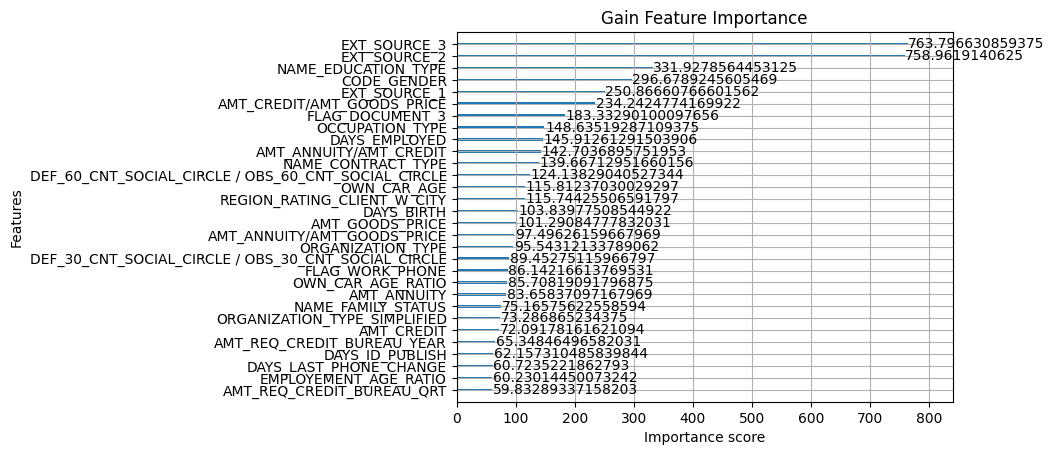

/Users/fdd838/Library/CloudStorage/OneDrive-Sky/Desktop/personal/home-credit-default-risk/processing_functions.py:228: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.



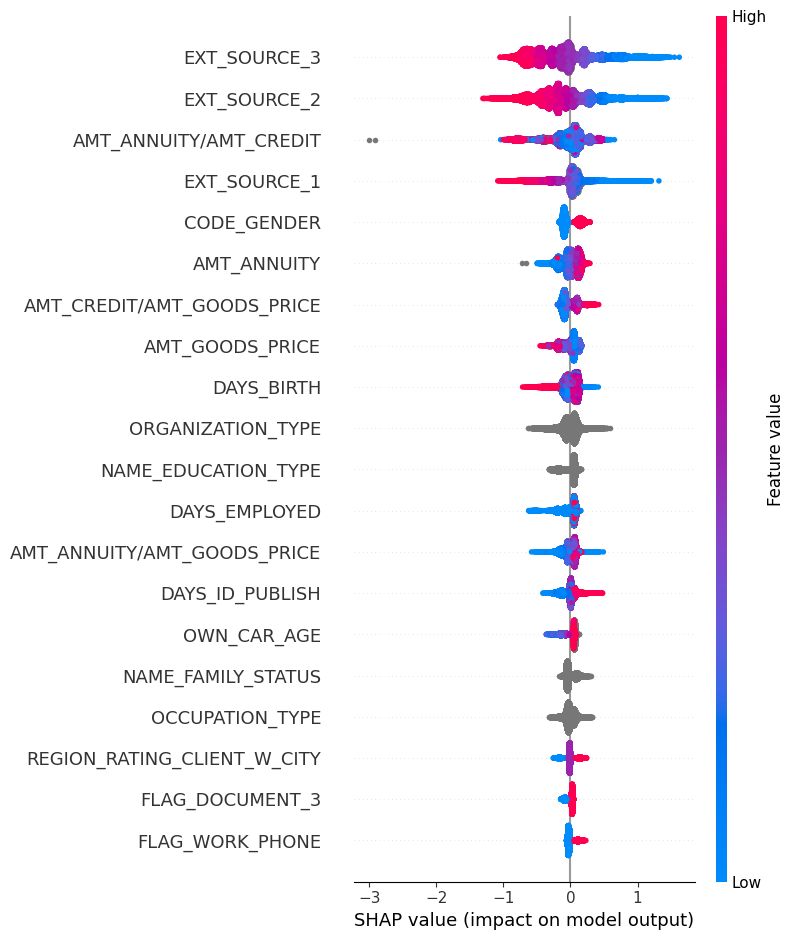

In [19]:
importance, shap_values, model = model_training_and_evaluation(
    params=params, 
    X_trainval=X_trainval[to_keep], 
    y_trainval=y_trainval,
    X_train=X_train[to_keep], 
    y_train=y_train,
    X_val=X_val[to_keep],
    y_val=y_val,
    X_test=X_test[to_keep], 
    submission_name="submission5", 
    seed=random_state,
    nfold=5, 
    num_boost_round=10000, 
    early_stopping_rounds=50,
    stratified=True, 
    metrics="auc",
)

In [20]:
#get_ordered_importance(importance)
shap_importance = get_ordered_shap_importance(X_val[to_keep], shap_values)
shap_importance

,Feature,shap_importance,%shap_importance,CUMSUM %shap_importance
0,EXT_SOURCE_3,0.385620,14.181711,14.181711
1,EXT_SOURCE_2,0.335518,12.339139,26.520851
2,AMT_ANNUITY/AMT_CREDIT,0.181464,6.673585,33.194435
3,EXT_SOURCE_1,0.165549,6.088292,39.282726
4,CODE_GENDER,0.113389,4.170029,43.452755
5,AMT_ANNUITY,0.099903,3.674064,47.126820
6,AMT_CREDIT/AMT_GOODS_PRICE,0.098175,3.610511,50.737331
7,AMT_GOODS_PRICE,0.091778,3.375280,54.112610
8,DAYS_BIRTH,0.085960,3.161314,57.273922
9,ORGANIZATION_TYPE,0.085684,3.151138,60.425060
